# Feature selection for classification -- Random forest
We use Random Forest for our binary classification of Blood Cancer. In particular, we will explore:
1. Variable Importance
1. Pruning (cost complexity)
1. ID3/C4.5 (NOT DONE)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

%matplotlib inline
plt.style.use('seaborn-white')

### 1. Understanding the data

In [4]:
blood_train = pd.read_csv("../../dataset/blood_training.csv")
blood_test = pd.read_csv("../../dataset/blood_test.csv")

In [5]:
blood_train.shape, blood_test.shape

((817, 17395), (205, 17395))

In [6]:
blood_train.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [7]:
blood_test.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [8]:
sum(blood_train.label == 1)/len(blood_train)

# only 11% of obs has labelled as blood cancer --> imbalanced class, thus need some more care
# Let us keep it as it is, later we adjust the minority class with SMOTE

0.11015911872705018

In [9]:
X_train = blood_train.drop(['DepMap_ID', 'label'], axis = 1)
y_train = blood_train['label']

X_test = blood_test.drop(['DepMap_ID', 'label'], axis = 1)
y_test = blood_test['label']

### 2. Random Forest classifier
Imbalance dataset, weighted class, NO pruning

In [15]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 50, n_estimators = 500,
                    max_depth = 40, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [16]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.996328029375765
Test score:  0.9902439024390244


In [21]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

# Probably mis classified 1 obs

The accuracy of the model is 99.0 %


(19, 19)

In [5]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 20,
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

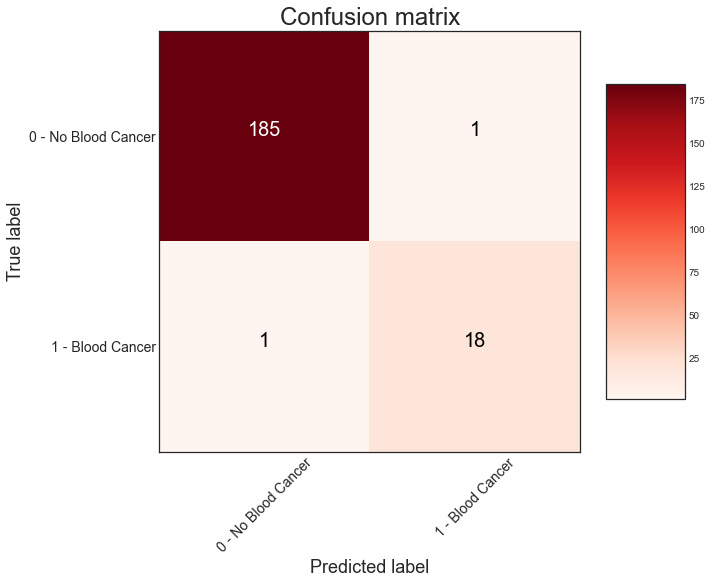

In [27]:
# Let us plot it
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Blood Cancer', '1 - Blood Cancer'])

In [98]:
# # Feature Importances
# # REM: the Random Forest Library implements the Gini Importance
# feat_impo = rf.feature_importances_

# # Then sort the feature importances by most important first
# feat_impo_ranked = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
# feat_impo_ranked = pd.DataFrame({"Gene":feat_impo_ranked.index, "Importance":feat_impo_ranked.values})

# # Print out the first 200 feature and importances
# for gene in range(200):
#     print(f"Gene '{feat_impo_ranked.Gene[gene]}' has Importance: {feat_impo_ranked.Importance[gene]}")

In [99]:
# feat_impo_ranked[feat_impo_ranked.Importance > 0.002]

In [84]:
feat_impo = pd.DataFrame(rf.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)

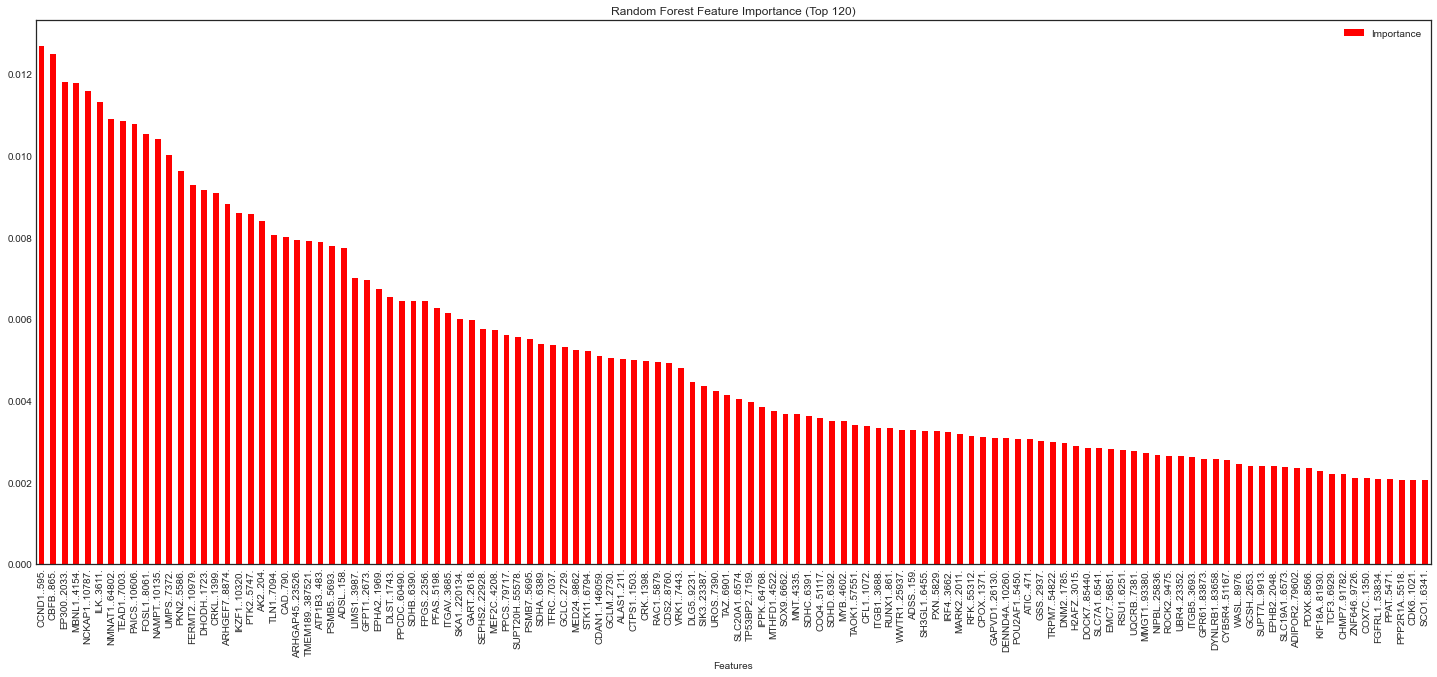

In [85]:
feat_impo[:120].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Top 120)')
plt.xlabel('Features')
plt.show()

In [11]:
# ROC curve plot

def evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} - Test: {round(results[metric], 2)}, Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k--', label = 'Baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
    plt.show()

In [44]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.99970961332722
Test ROC AUC Score: 0.9994340690435767


Recall Baseline: 1.0 - Test: 0.95, Train: 0.99
Precision Baseline: 0.09 - Test: 0.95, Train: 0.98
Roc Baseline: 0.5 - Test: 1.0, Train: 1.0


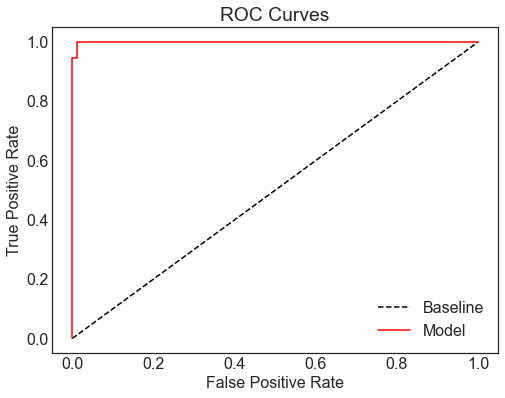

In [60]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

We are very proud of this classification. Even if the dataset is imbalanced, the build-in algorithm adapts well giving proper weigths.

### 3. 5-fold cross validation and Feature selection
Let us try a 5-fold cross-validation to validate the model's performance and finding the optimal parameters

In [ ]:
# Our current parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [50]:
# 5-Fold Cross validation to validate the model
rf_cl = RandomForestClassifier(oob_score = True)
np.mean(cross_val_score(rf_cl, X_train, y_train, cv = 5))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

0.9522220559628909

Let us use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'.

In [67]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 68, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int)),
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(
                estimator = rf_cl,
                param_distributions = random_grid,
                n_iter = 2, cv = 5,
                verbose = 2, random_state = 2311, 
                scoring = 'roc_auc')

In [97]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.4min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.2min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.4min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.3min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.4min
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 15, 21, 28, 35, 41,
                                                      48, 54, 61, 68, None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12,
                                                           12, 13, 13, 13, 13,
                                                           13, 14, 14, 14, 14,
                                                           14, 15, 15, 15, 15, ...],
                                        'min_samples_leaf': [1, 4, 10],
                                        'mi

In [100]:
rf_random.best_params_

{'n_estimators': 504,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 35,
 'max_features': 'auto',
 'max_depth': 48,
 'bootstrap': True}

In [101]:
rf_random.cv_results_

{'mean_fit_time': array([80.04513164,  0.49620404]),
 'std_fit_time': array([4.61192877, 0.0265703 ]),
 'mean_score_time': array([0.27548089, 0.        ]),
 'std_score_time': array([0.01480031, 0.        ]),
 'param_n_estimators': masked_array(data=[504, 516],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[4, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[35, 45],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'log2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[48, 35],
              mask=[False, False],

Our aim now is to remove unnecessary features from the data to reduce noise and possibly get better performance. In particular, we will perform a 5-fold cross validation to reach this aim. The idea is to get the feature importance values from each of the 5 models built in the 5-fold cross-validation and then take the average of the 5 importance values for each feature in order to select the top N features for the final model.

In [72]:
rf_cl = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                n_estimators = 500, class_weight = 'balanced_subsample',
                bootstrap = True, oob_score = True)

out = cross_validate(rf_cl, X_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [73]:
type(out)

dict

In [145]:
feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = X_train.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.001])

First 10 features sorted by their importance for model n. 1:
                Importance1
ILK..3611.         0.010838
MBNL1..4154.       0.010211
CCND1..595.        0.009844
NAMPT..10135.      0.009020
CBFB..865.         0.008812
NCKAP1..10787.     0.008500
NMNAT1..64802.     0.008401
PKN2..5586.        0.008071
FOSL1..8061.       0.007988
IKZF1..10320.      0.007890
--------------------------------
First 10 features sorted by their importance for model n. 2:
                Importance2
ILK..3611.         0.009922
CBFB..865.         0.009879
NAMPT..10135.      0.009707
NCKAP1..10787.     0.009122
CCND1..595.        0.008981
FERMT2..10979.     0.008912
PKN2..5586.        0.008737
MBNL1..4154.       0.008585
CRKL..1399.        0.008082
TEAD1..7003.       0.007798
--------------------------------
First 10 features sorted by their importance for model n. 3:
                  Importance3
MBNL1..4154.         0.010353
ILK..3611.           0.010295
CBFB..865.           0.010114
CCND1..595.    

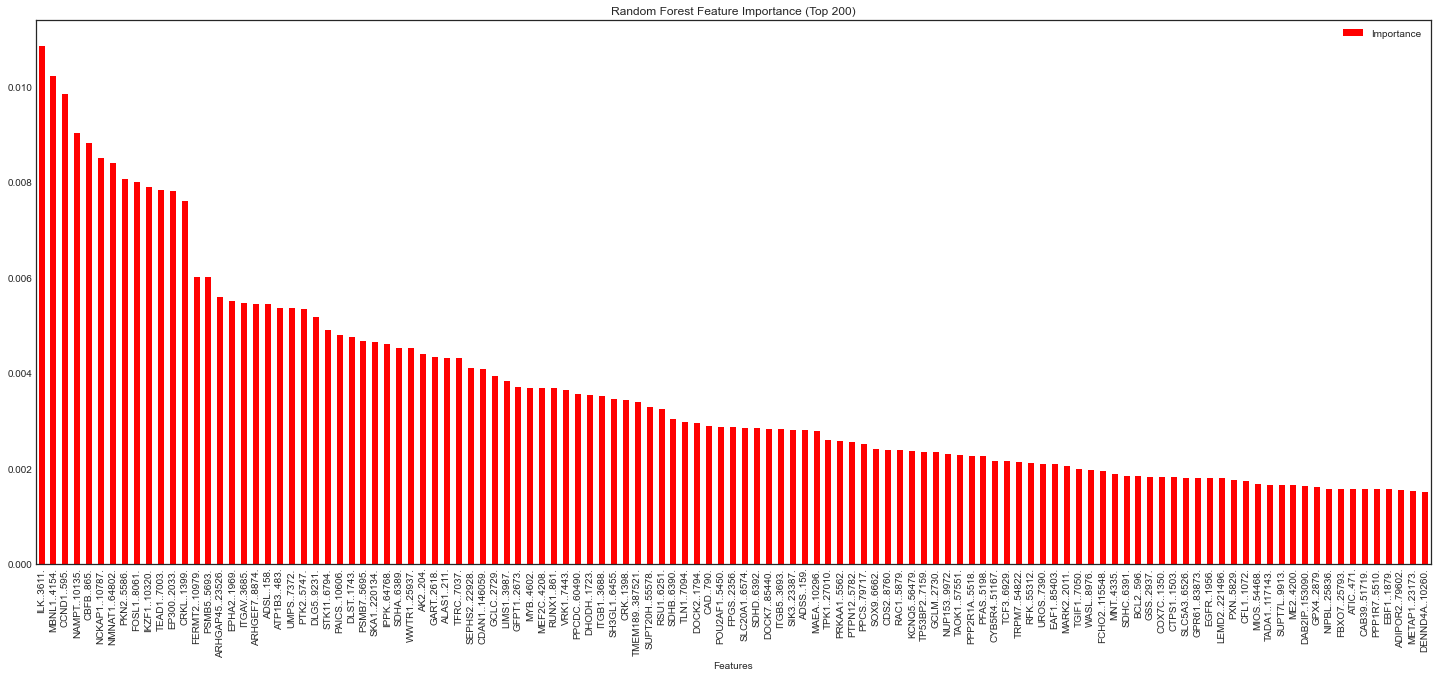

In [109]:
feat_impo_all[0].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Model n. 1)')
plt.xlabel('Features')
plt.show()

In [ ]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

In [ ]:
feat_impo_all[2].plot.bar(figsize = (25, 10), color = 'g')
plt.title('Random Forest Feature Importance (Model n. 3)')
plt.xlabel('Features')
plt.show()

In [ ]:
feat_impo_all[3].plot.bar(figsize = (25, 10), color = 'y')
plt.title('Random Forest Feature Importance (Model n. 4)')
plt.xlabel('Features')
plt.show()

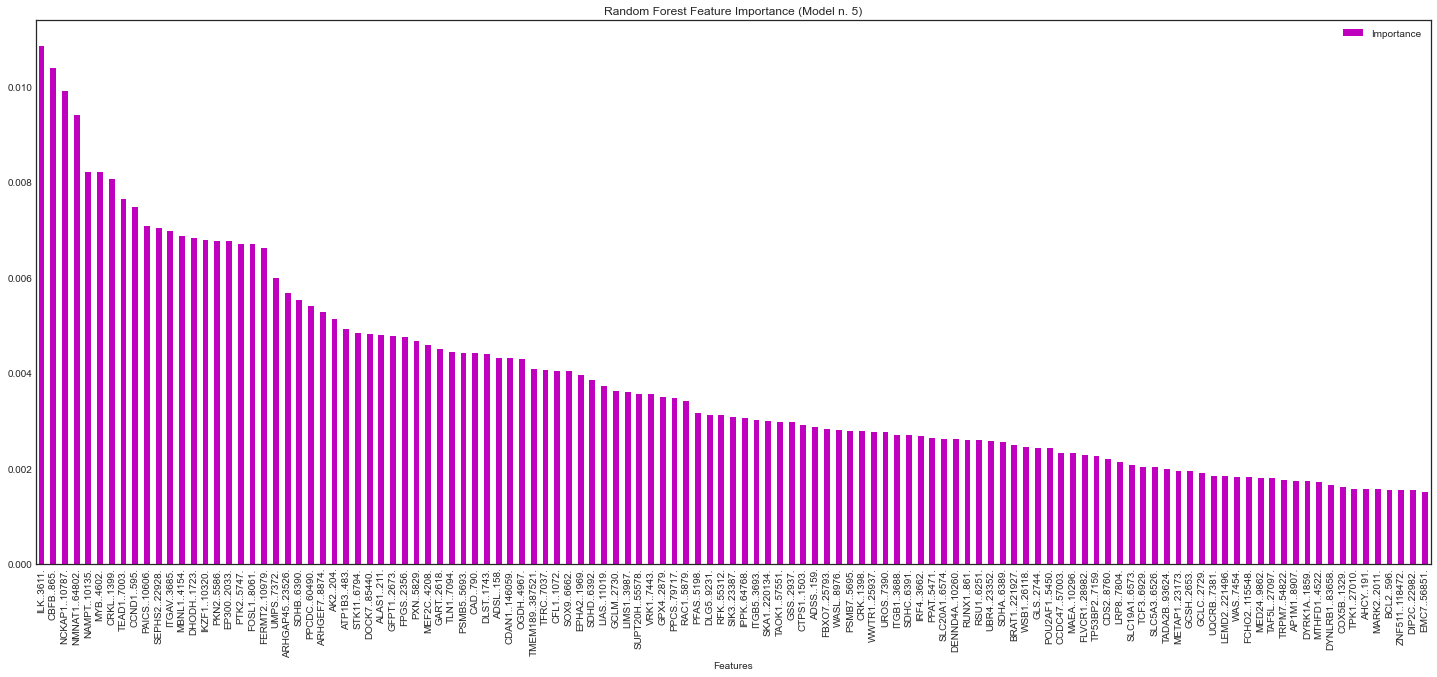

In [110]:
feat_impo_all[4].plot.bar(figsize = (25, 10), color = 'm')
plt.title('Random Forest Feature Importance (Model n. 5)')
plt.xlabel('Features')
plt.show()

In [146]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

In [182]:
most_feat_impo = pd.concat([df0, df1, df2, df3, df4], axis = 1)
most_feat_impo

,Importance1,Importance2,Importance3,Importance4,Importance5
ILK..3611.,0.010838,0.009922,0.010295,0.009633,0.010835
MBNL1..4154.,0.010211,0.008585,0.010353,0.009325,0.006872
CCND1..595.,0.009844,0.008981,0.009776,0.006391,0.007467
NAMPT..10135.,0.009020,0.009707,0.009309,0.008140,0.008211
CBFB..865.,0.008812,0.009879,0.010114,0.013678,0.010374
...,...,...,...,...,...
WAS..7454.,NaN,NaN,NaN,NaN,0.001831
TAF5L..27097.,NaN,NaN,NaN,NaN,0.001792
AP1M1..8907.,NaN,NaN,NaN,NaN,0.001747
DYNLRB1..83658.,NaN,NaN,NaN,NaN,0.001648


In [193]:
most_feat_impo = most_feat_impo.dropna()
most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)
most_feat_impo

,Importance1,Importance2,Importance3,Importance4,Importance5,Importance_mean
ILK..3611.,0.010838,0.009922,0.010295,0.009633,0.010835,0.010305
MBNL1..4154.,0.010211,0.008585,0.010353,0.009325,0.006872,0.009069
CCND1..595.,0.009844,0.008981,0.009776,0.006391,0.007467,0.008492
NAMPT..10135.,0.009020,0.009707,0.009309,0.008140,0.008211,0.008877
CBFB..865.,0.008812,0.009879,0.010114,0.013678,0.010374,0.010571
...,...,...,...,...,...,...
CTPS1..1503.,0.001814,0.002362,0.003389,0.002439,0.002900,0.002581
SLC5A3..6526.,0.001811,0.001669,0.002130,0.002930,0.002026,0.002113
PXN..5829.,0.001750,0.002219,0.002867,0.003287,0.004664,0.002957
CFL1..1072.,0.001740,0.002109,0.003316,0.002183,0.004051,0.002680


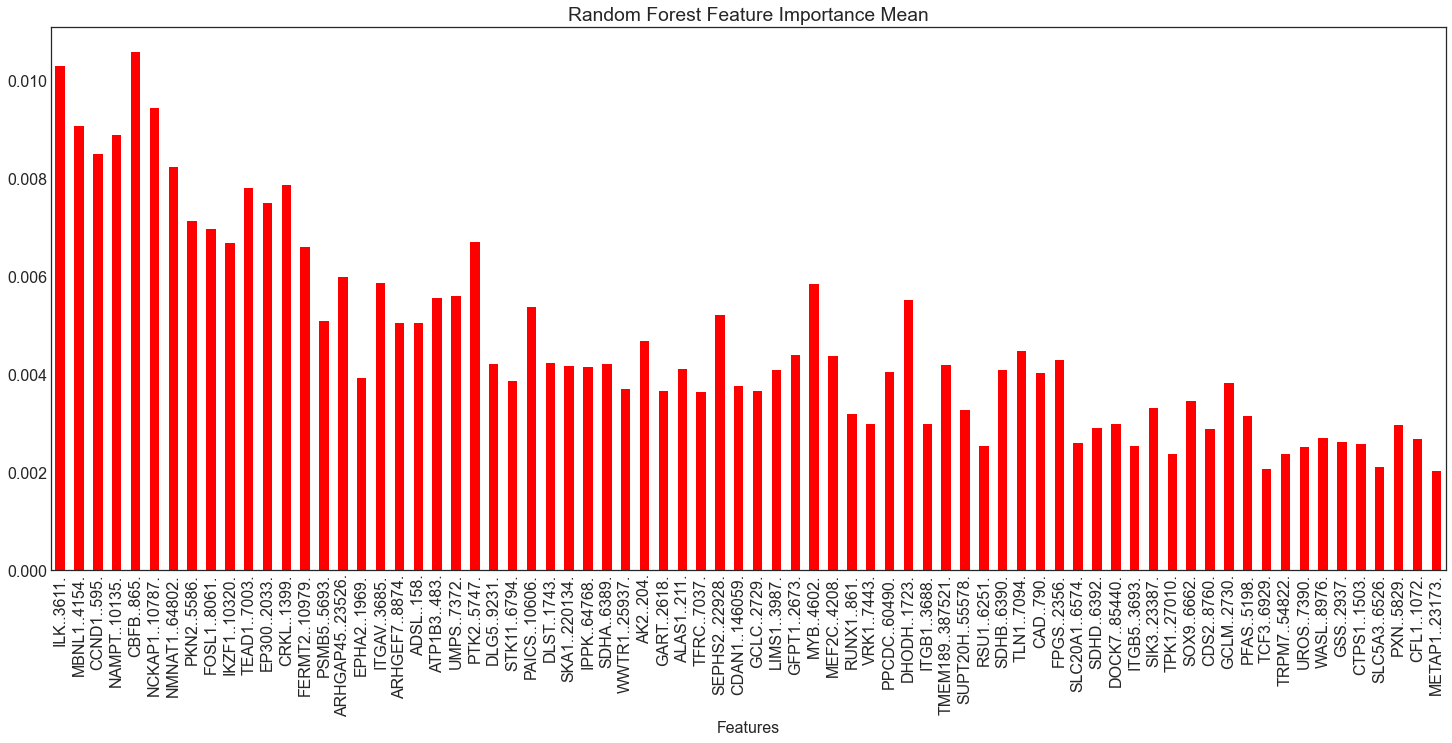

In [196]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()

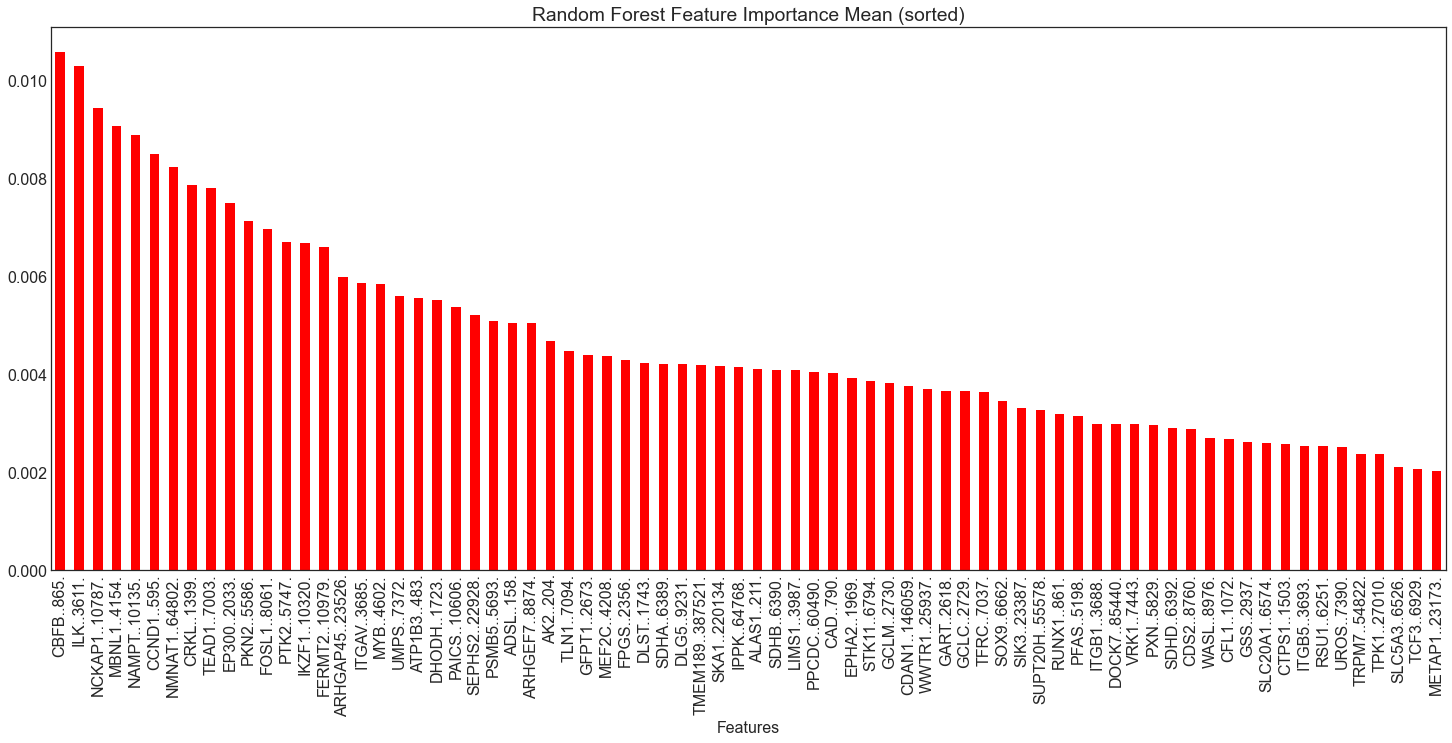

In [198]:
most_feat_impo = most_feat_impo.sort_values('Importance_mean', ascending = False)
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean (sorted)')
plt.xlabel('Features')
plt.show()

--------------------

--------------------
**Questions**: If I do average the 5 feature importance values for each feature, select the top 200, and then do another 5-fold cross-validation on the model with the top 200 features, is it meaningful? Or will this cause leaking and overfitting since the feature selection was based off of all the data because I averaged the importances from all 5 models from the cross-validation?

A more rigorous way to pursue this question is to apply the **Boruta algorithm**. Boruta repeatedly measures feature importance from a random forest (or similar method) and then carries out statistical tests to screen out the features which are irrelevant. The procedure terminates when all features are either decisively relevant or decisively irrelevant.


SEE LATER

--------------------

--------------------

### 4. Pruned Random Forest classifier
Imbalance dataset, weighted class.

Looking at the documentation of RandomForestClassifier, we see the attribute *ccp_alpha* (non-negative float, default = 0.0).

This is the complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

In [6]:
rf_pruned = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                        ccp_alpha = 0.001,
                        n_estimators = 500, min_samples_leaf = 4, 
                        min_samples_split = 10, max_leaf_nodes = 35,
                        max_depth = 48, class_weight = "balanced_subsample",
                        bootstrap = True, oob_score = True)

rf_pruned.fit(X_train, y_train)
print('Training score: ', rf_pruned.score(X_train, y_train))
print('Test score: ', rf_pruned.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.9804878048780488


The accuracy of the model is 98.0 %
Predicted vs. True: (15, 19)


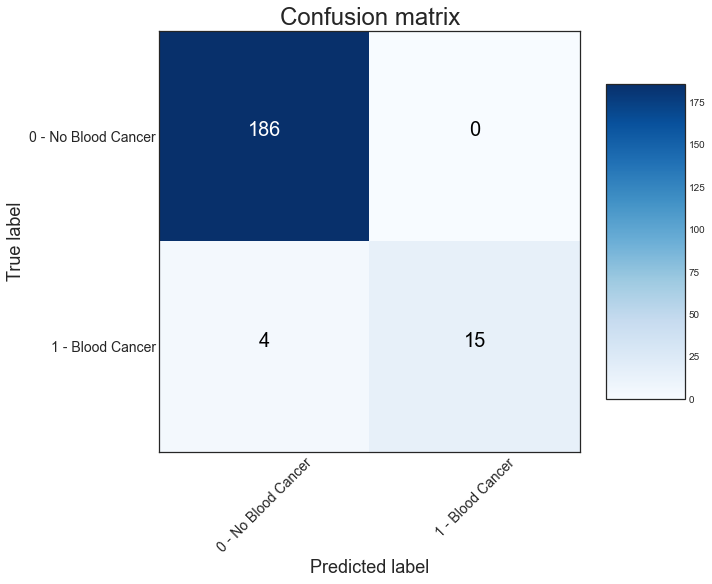

In [9]:
y_pred = rf_pruned.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Blood Cancer', '1 - Blood Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Blues)

# Worse

Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.9997170345217884
Recall Baseline: 1.0 - Test: 0.79, Train: 1.0
Precision Baseline: 0.09 - Test: 1.0, Train: 1.0
Roc Baseline: 0.5 - Test: 1.0, Train: 1.0


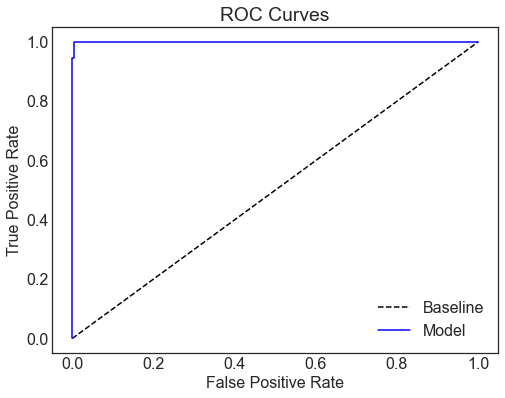

In [12]:
train_predictions = rf_pruned.predict(X_train)
train_probs = rf_pruned.predict_proba(X_train)[:, 1]
probs = rf_pruned.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

# ROC Curve
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

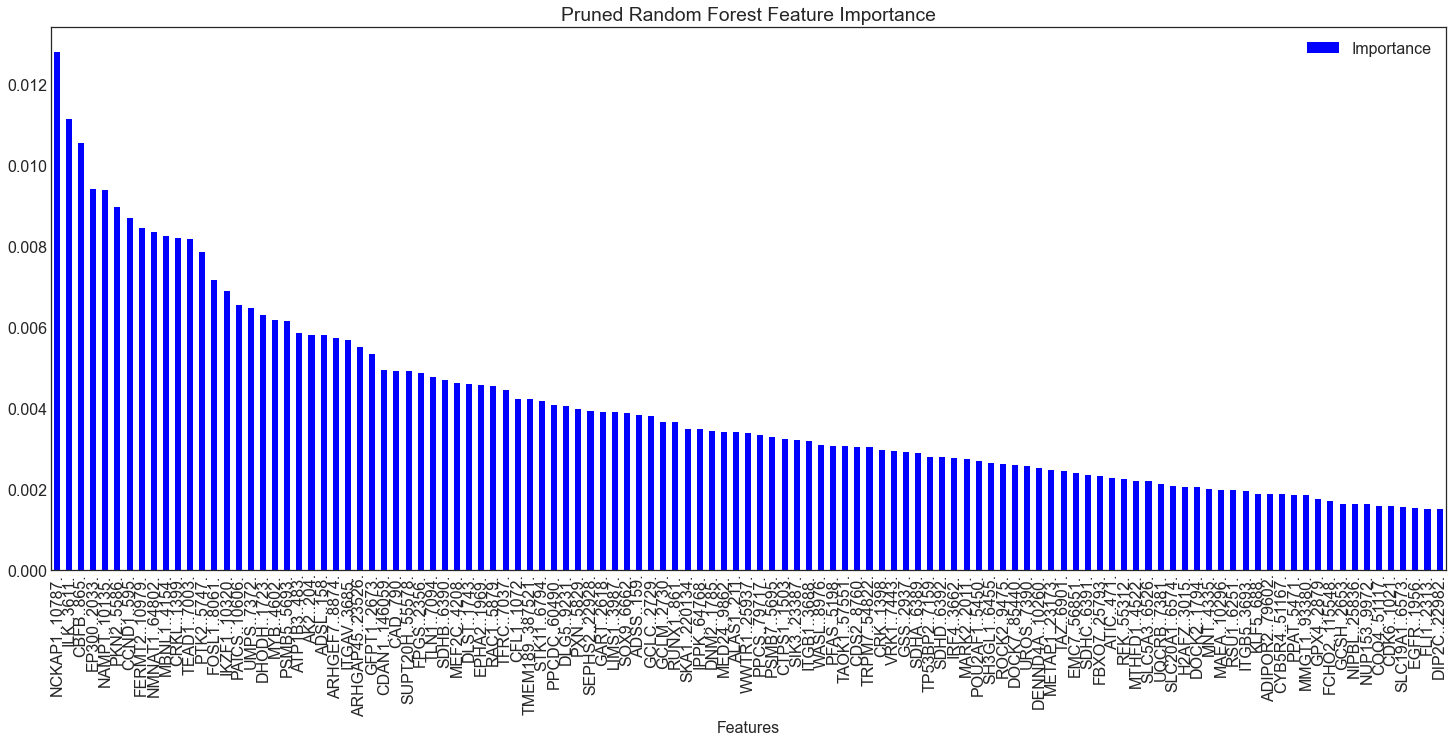

In [167]:
feat_impo_new = pd.DataFrame(rf_pruned.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)
                        
feat_impo_new[feat_impo_new.Importance > 0.001].plot.bar(figsize = (25, 10), color = 'b')
plt.title('Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()

In [189]:
select_feat = feat_impo_new.loc[most_feat_impo.index]
select_feat = select_feat.sort_values('Importance', ascending = False)

In [10]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()


select_feat.plot.bar(figsize = (25, 10), color = 'b')
plt.title('Selected Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()

# cosa carina: plottarli assieme, con le barre uno di fianco all'altro

NameError: name 'most_feat_impo' is not defined

### 5. Boruta algorithm
**Questions**: If I do average the 5 feature importance values for each feature, select the top 200, and then do another 5-fold cross-validation on the model with the top 200 features, is it meaningful? Or will this cause leaking and overfitting since the feature selection was based off of all the data because I averaged the importances from all 5 models from the cross-validation?

A more rigorous way to pursue this question is to apply the **Boruta algorithm**. 

Boruta repeatedly measures feature importance from a Random Forest (or similar method) and then carries out statistical tests to screen out the features which are irrelevant. The procedure terminatess when a score has been generated for all the features (aka all features are either decisively relevant or decisively irrelevant), or we reach the maximum runs set for the random forest. Here the steps of Boruta algorithm:

1. Create copies of all the original features present in your dataset.
1. Add randomness by shuffling these new feature. This is done to ensure that these new features show no correlation with the response variable.
1. Run random forest classifier on the extended dataset and generate feature importance score based on mean accuracy decrease estimate for all the shadow variables.
1. Compare Z-score of original variable with the maximum Z-score of shadow variables. Real features that have low score compared to the best of shadow features are deemed unimportant.
1. Remove shadow features and repeat the process until an importance score is generated for all the variables.

In [10]:
from boruta import BorutaPy

In [11]:
# Defining Random Forest Classifier as above
rf_cl = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                n_estimators = 500, class_weight = 'balanced_subsample',
                bootstrap = True, oob_score = True)

rf_cl.fit(X_train, y_train)

/Users/laburd/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=2311)

In [12]:
# Defining parameters of boruta object for feature selection
feat_selection = BorutaPy(rf_cl, n_estimators = 'auto', verbose = 1, 
                        max_iter = 50, random_state = 2311)

# Only 3 iterations since time consuming (dafult is 100)
# At least 30 minutes

# Get relevant features
feat_selection.fit(np.array(X_train), np.array(y_train))

Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 / 50
Iteration: 38 / 50
Iteration: 39 / 50
Iteration: 40 / 50
Iteration: 41 / 50
Iteration: 42 / 50
Iteration: 43 / 50
Iteration: 44 / 50
Iteration: 45 / 50
Iteration: 46 / 50
Iteration: 47 / 50
Iteration: 48 / 50
Iteration: 49 / 50


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	267
Tentative: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                          n_estimators=289, n_jobs=-1,
                                          oob_score=True,
                                          random_state=RandomState(MT19937) at 0x282C1B340),
         max_iter=50, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x282C1B340, verbose=1)

In [13]:
# Getting all relevant features
feat_selection.support_

array([False, False, False, ..., False, False, False])

In [14]:
# Getting feature ranking
feat_selection.ranking_

array([8406, 7306, 3371, ..., 5944, 6576, 5721])

In [15]:
# Selecting only selected features by using transform() function
feat_selection.transform(np.array(X_train))

array([[0.01014304, 0.10772826, 0.01530246, ..., 0.95467682, 0.0530655 ,
        0.0485438 ],
       [0.01817396, 0.11633763, 0.10462268, ..., 0.13773908, 0.12394739,
        0.01204027],
       [0.05855398, 0.43246456, 0.04677443, ..., 0.29446629, 0.05798369,
        0.01558405],
       ...,
       [0.0357983 , 0.09841161, 0.01536656, ..., 0.14373528, 0.02951203,
        0.0149436 ],
       [0.01229555, 0.31594874, 0.03244713, ..., 0.1386356 , 0.13228546,
        0.0330417 ],
       [0.04638911, 0.02866412, 0.01915507, ..., 0.55590314, 0.7535802 ,
        0.04194105]])

In [16]:
# Creating list of varibale name, ranks, and final decision using zip
feat_rankings = list(zip(X_train.columns,
                           feat_selection.ranking_,
                           feat_selection.support_))

# Printing the list of varibales which got selected
count = 0
for i in feat_rankings:
    if i[2] == True:
        count += 1
        print(f'count: {count}  Name: {i[0]} Rank: {i[1]}')

count: 1  Name: AAR2..25980. Rank: 1
count: 2  Name: ACSL4..2182. Rank: 1
count: 3  Name: ADD1..118. Rank: 1
count: 4  Name: ADIPOR2..79602. Rank: 1
count: 5  Name: ADSL..158. Rank: 1
count: 6  Name: ADSS..159. Rank: 1
count: 7  Name: AFF1..4299. Rank: 1
count: 8  Name: AGPS..8540. Rank: 1
count: 9  Name: AHCY..191. Rank: 1
count: 10  Name: AK2..204. Rank: 1
count: 11  Name: AKT2..208. Rank: 1
count: 12  Name: ALAD..210. Rank: 1
count: 13  Name: ALAS1..211. Rank: 1
count: 14  Name: AP2M1..1173. Rank: 1
count: 15  Name: ARHGAP29..9411. Rank: 1
count: 16  Name: ARHGAP45..23526. Rank: 1
count: 17  Name: ARHGEF7..8874. Rank: 1
count: 18  Name: ATIC..471. Rank: 1
count: 19  Name: ATP1B3..483. Rank: 1
count: 20  Name: ATP6AP2..10159. Rank: 1
count: 21  Name: AZIN1..51582. Rank: 1
count: 22  Name: B3GAT3..26229. Rank: 1
count: 23  Name: BCL2..596. Rank: 1
count: 24  Name: BCL2A1..597. Rank: 1
count: 25  Name: BIRC6..57448. Rank: 1
count: 26  Name: BRAT1..221927. Rank: 1
count: 27  Name: BRIP1